# Method 2: Walk-Forward-Validation

## Preparation

In [1]:
%run "/Users/joel.gysel/GoogleDrive/Masterarbeit/04_code/jupyter/01_Preparation.ipynb"

Running file completed


In [2]:
%run "/Users/joel.gysel/GoogleDrive/Masterarbeit/04_code/jupyter/_config.ipynb"

Running file completed


## Individual Classifiers

In [152]:
# classifiers_list = [classifiers_naive, classifiers_lr, classifiers_tree]

In [160]:
results_single = pd.DataFrame()
pasts = [all]
future = 3


for classifiers in classifiers_list:
    
    for classifier in classifiers:
        print(classifier.__class__.__name__)

        for sampler in samplers: 
            if sampler == "none":
                samplersymbol = "No oversampling"
                print(samplersymbol)
            else:
                samplersymbol = str(sampler.__class__.__name__) + str(sampler.sampling_strategy)
                print(samplersymbol)
 

            if classifier.__class__.__name__ == "Perceptron":
                keysymbol = " "
            if classifier.__class__.__name__ == "LogisticRegression":
                keysymbol = "C = " + str(classifier.C)
            if classifier.__class__.__name__ == "DecisionTreeClassifier":
                keysymbol = "MD = " + str(classifier.max_depth)
            if classifier.__class__.__name__ == "RandomForestClassifier":
                keysymbol = "Nr. of Trees = " + str(classifier.n_estimators)
            if classifier.__class__.__name__ == "AdaBoostClassifier":
                keysymbol = "Nr. of Estim. = " + str(classifier.n_estimators) + ", LR = " + str(classifier.learning_rate)
            if classifier.__class__.__name__ == "GradientBoostingClassifier":
                keysymbol = "Nr. of Estim. = " + str(classifier.n_estimators) + ", LR = " + str(classifier.learning_rate)
            if classifier.__class__.__name__ == "XGBClassifier":
                keysymbol = "LR = " + str(classifier.learning_rate)
            if classifier.__class__.__name__ == "KNeighborsClassifier":
                keysymbol = "Nr. of Neighb. = " + str(classifier.n_neighbors)
            if classifier.__class__.__name__ == "GaussianNB":
                keysymbol = " " 
            if classifier.__class__.__name__ == "SVC":
                keysymbol = "Gamma =" + str(classifier.gamma) + ", C =" + str(classifier.C)
            print(keysymbol)


            for vars in varlist:
                print(vars)

                accuracy_list  = []
                precision_list = []
                recall_list    = []
                f1value_list   = []
                f2value_list   = []
                ap_list        = []


                for past in pasts:


                    for i in range(1980, 1999):

                        #### Create sample
                        if past is all: 
                            train_X = pd_data[(pd_data.Year <= i)][vars]
                            train_y = pd_data[(pd_data.Year <= i)]["Default"]
                        else: 
                            train_X = pd_data[(pd_data.Year <= i) & (pd_data.Year >= (i - past))][vars]
                            train_y = pd_data[(pd_data.Year <= i) & (pd_data.Year >= (i - past))]["Default"]

                        if future is all: 
                            test_X  = pd_data[(pd_data.Year >  i)][vars]
                            test_y  = pd_data[(pd_data.Year >  i)]["Default"]
                        else: 
                            test_X  = pd_data[(pd_data.Year >= i+1) & (pd_data.Year <= i+1+future)][vars]
                            test_y  = pd_data[(pd_data.Year >= i+1) & (pd_data.Year <= i+1+future)]["Default"]


                        #### Make Prediction
                        if classifier.__class__.__name__ == "Perceptron":
                            pred   = [1] * len(test_X)
                            proba  = [1] * len(test_X)
                        
                        else:
                            if sampler == "none":
                                classifier.fit(train_X, train_y)                
                            else:
                                X_resampled, y_resampled = sampler.fit_resample(train_X, train_y) 
                                classifier.fit(X_resampled, y_resampled) 

                                # print(f"     Before resampling: {sorted(Counter(train_y).items())}")
                                # print(f"     After resampling:  {sorted(Counter(y_resampled).items())}")

                            # Predictions
                            pred   = classifier.predict(test_X)
                            proba  = classifier.predict_proba(test_X)[:,1]  
                            

                        #### Evaluate
                        accuracy  = accuracy_score(test_y, pred)
                        accuracy_list.append(accuracy)
                        precision = precision_score(test_y, pred)
                        precision_list.append(precision)
                        recall    = recall_score(test_y, pred)
                        recall_list.append(recall)
                        f1value    = fbeta_score(test_y, pred, average='binary', beta=1)
                        f1value_list.append(f1value)
                        f2value    = fbeta_score(test_y, pred, average='binary', beta=2)
                        f2value_list.append(f2value)
                        ap        = metrics.average_precision_score(test_y, proba)
                        ap_list.append(ap)

                        # Curves
                        precision, recall, tresh = metrics.precision_recall_curve(test_y, proba)


                    # Matrix with results                  
                    newrow  = pd.DataFrame({"Model"        : [classifier],
                                            "Classifier"   : [classifier.__class__.__name__],
                                            "Hyperparam."  : [keysymbol],
                                            "Sampler"      : [samplersymbol],
                                            "Vars"         : [len(vars)],
                                            "Past"         : [past], 
                                            "Accuracy"     : [statistics.mean(accuracy_list)],
                                            "Precision"    : [statistics.mean(precision_list)],
                                            "Recall"       : [statistics.mean(recall_list)],
                                            "F1"           : [statistics.mean(f1value_list)],
                                            "F1 Var"       : [statistics.variance(f1value_list)],
                                            "F2"           : [statistics.mean(f2value_list)],
                                            "F2 Var"       : [statistics.variance(f2value_list)],
                                            "AP"           : [statistics.mean(ap_list)],
                                            "Maximum"      : [0]})  
                    results_single = pd.concat([results_single, newrow], ignore_index = True)


    results_single.loc[(results_single["Classifier"] == classifier.__class__.__name__) & 
                       (results_single["F2"] == max(results_single[results_single.Classifier == classifier.__class__.__name__]["F2"])), 
                       "Maximum"] = 1
                    
# Export results to excel
results_single.to_excel(f"05_output/Tables/WF_Single.xlsx")
results_single.to_csv("05_output/WF_Single.csv")


Perceptron
RandomOverSampler1.0
 
['STDR']
['STDR', 'M2R']
['STDR', 'M2R', 'ResG']
['STDR', 'M2R', 'ResG', 'DSER']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG', 'RGRWT']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG', 'RGRWT', 'FDIG']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG', 'RGRWT', 'FDIG', 'OPEN']
Logistic

['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG', 'RGRWT']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG', 'RGRWT', 'FDIG']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG', 'RGRWT', 'FDIG', 'OPEN']
DecisionTreeClassifier
RandomOverSampler1.0
MD = 4
['STDR']
['STDR', 'M2R']
['STDR', 'M2R', 'ResG']
['STDR', 'M2R', 'ResG', 'DSER']
['STDR', 'M2R', 'ResG', 'DSER'

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG', 'RGRWT', 'FDIG', 'OPEN']
DecisionTreeClassifier
RandomOverSampler1.0
MD = 9
['STDR']
['STDR', 'M2R']
['STDR', 'M2R', 'ResG']
['STDR', 'M2R', 'ResG', 'DSER']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG', 'RGRWT']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG', 'RGRWT',

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


DecisionTreeClassifier
RandomOverSampler1.0
MD = 15
['STDR']
['STDR', 'M2R']
['STDR', 'M2R', 'ResG']
['STDR', 'M2R', 'ResG', 'DSER']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG', 'RGRWT']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG', 'RGRWT', 'FDIG']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG', 'RGRWT', 'FDIG', 'OPEN']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


DecisionTreeClassifier
RandomOverSampler1.0
MD = 20
['STDR']
['STDR', 'M2R']
['STDR', 'M2R', 'ResG']
['STDR', 'M2R', 'ResG', 'DSER']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG', 'RGRWT']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG', 'RGRWT', 'FDIG']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG', 'RGRWT', 'FDIG', 'OPEN']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RandomForestClassifier
RandomOverSampler1.0
Nr. of Trees = 10
['STDR']
['STDR', 'M2R']
['STDR', 'M2R', 'ResG']
['STDR', 'M2R', 'ResG', 'DSER']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision 

['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG', 'RGRWT']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision 

['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG', 'RGRWT', 'FDIG']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG', 'RGRWT', 'FDIG', 'OPEN']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision 

RandomForestClassifier
RandomOverSampler1.0
Nr. of Trees = 25
['STDR']
['STDR', 'M2R']
['STDR', 'M2R', 'ResG']
['STDR', 'M2R', 'ResG', 'DSER']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG', 'RGRWT']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG', 'RGRWT', 'FDIG']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG', 'RGRWT', 'FDIG', 'OPEN']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision 

RandomForestClassifier
RandomOverSampler1.0
Nr. of Trees = 50
['STDR']
['STDR', 'M2R']
['STDR', 'M2R', 'ResG']
['STDR', 'M2R', 'ResG', 'DSER']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision 

['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG', 'RGRWT']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision 

['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG', 'RGRWT', 'FDIG']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision 

['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG', 'RGRWT', 'FDIG', 'OPEN']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision 

RandomForestClassifier
RandomOverSampler1.0
Nr. of Trees = 100
['STDR']
['STDR', 'M2R']
['STDR', 'M2R', 'ResG']
['STDR', 'M2R', 'ResG', 'DSER']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision 

['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG', 'RGRWT']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision 

['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG', 'RGRWT', 'FDIG']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision 

['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG', 'RGRWT', 'FDIG', 'OPEN']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision 

RandomForestClassifier
RandomOverSampler1.0
Nr. of Trees = 500
['STDR']
['STDR', 'M2R']
['STDR', 'M2R', 'ResG']
['STDR', 'M2R', 'ResG', 'DSER']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision 

['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision 

['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG', 'RGRWT']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision 

['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG', 'RGRWT', 'FDIG']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision 

['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG', 'RGRWT', 'FDIG', 'OPEN']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision 

AdaBoostClassifier
RandomOverSampler1.0
Nr. of Estim. = 10, LR = 0.1
['STDR']
['STDR', 'M2R']
['STDR', 'M2R', 'ResG']
['STDR', 'M2R', 'ResG', 'DSER']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG', 'RGRWT']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG', 'RGRWT', 'FDIG']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG'

AdaBoostClassifier
RandomOverSampler1.0
Nr. of Estim. = 100, LR = 0.1
['STDR']
['STDR', 'M2R']
['STDR', 'M2R', 'ResG']
['STDR', 'M2R', 'ResG', 'DSER']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG', 'RGRWT']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG', 'RGRWT', 'FDIG']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AdaBoostClassifier
RandomOverSampler1.0
Nr. of Estim. = 1000, LR = 1.0
['STDR']
['STDR', 'M2R']
['STDR', 'M2R', 'ResG']
['STDR', 'M2R', 'ResG', 'DSER']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG', 'RGRWT']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG', 'RGRWT', 'FDIG']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'X

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG', 'RGRWT', 'FDIG', 'OPEN']
GradientBoostingClassifier
RandomOverSampler1.0
Nr. of Estim. = 100, LR = 0.5
['STDR']
['STDR', 'M2R']
['STDR', 'M2R', 'ResG']
['STDR', 'M2R', 'ResG', 'DSER']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG', 'RGRWT']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'U

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


GradientBoostingClassifier
RandomOverSampler1.0
Nr. of Estim. = 100, LR = 1.0
['STDR']
['STDR', 'M2R']
['STDR', 'M2R', 'ResG']
['STDR', 'M2R', 'ResG', 'DSER']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG', 'RGRWT']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG', 'RGRWT', 'FDIG']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG', 'RGRWT', 'FDIG', 'OPEN']
GradientBoostingClassifier
RandomOverSampler1.0
Nr. of Estim. = 100, LR = 2.0
['STDR']
['STDR', 'M2R']
['STDR', 'M2R', 'ResG']
['STDR', 'M2R', 'ResG', 'DSER']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG', 'RGRWT']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG', 'RGRWT', 'FDIG']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG', 'RGRWT', 'FDIG', 'OPEN']
GradientBoostingClassifier
RandomOverSampler1.0
Nr. of Estim. = 1000, LR = 0.1
['STDR']
['STDR', 'M2R']
['STDR', 'M2R', 'ResG']
['STDR', 'M2R', 'ResG', 'DSER']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG', 'RGRWT']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG', 'RGRWT', 'FDIG']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG', 'RGRWT', 'FDIG', 'OPEN']
GradientBoostingClassifier
RandomOverSampler1.0
Nr. of Estim. = 1000, LR = 2.0
['STDR']
['STDR', 'M2R']
['STDR', 'M2R', 'ResG']
['STDR', 'M2R', 'ResG', 'DSER']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SED

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG', 'RGRWT']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG', 'RGRWT', 'FDIG']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG', 'RGRWT', 'FDIG', 'OPEN']
XGBClassifier
RandomOverSampler1.0
LR = 0.01
['STDR']
['STDR', 'M2R']
['STDR', 'M2R', 'ResG']
['STDR', 'M2R', 'ResG', 'DSER']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG', 'RGRWT

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG', 'RGRWT']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG', 'RGRWT', 'FDIG']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG', 'RGRWT', 'FDIG', 'OPEN']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


KNeighborsClassifier
RandomOverSampler1.0
Nr. of Neighb. = 1
['STDR']
['STDR', 'M2R']
['STDR', 'M2R', 'ResG']
['STDR', 'M2R', 'ResG', 'DSER']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG', 'RGRWT']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG', 'RGRWT', 'FDIG']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG', 'RGRWT

['STDR', 'M2R', 'ResG', 'DSER', 'CAY']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG', 'RGRWT']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG', 'RGRWT', 'FDIG']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG', 'RGRWT', 'FDIG', 'OPEN']
SVC
RandomOverSampler1.0
Gamma =1, C =0.01
['STDR']
['STDR', 'M2R']
['STDR', 'M2R', 'ResG']
['STDR', 'M2R', 'ResG', 'DSER']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG', 'RGRWT']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG', 'RGRWT', 'FDIG']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG', 'RGRWT', 'FDIG', 'OPEN']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision 

SVC
RandomOverSampler1.0
Gamma =1, C =1
['STDR']
['STDR', 'M2R']
['STDR', 'M2R', 'ResG']
['STDR', 'M2R', 'ResG', 'DSER']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision 

['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision 

['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG', 'RGRWT']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision 

['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG', 'RGRWT', 'FDIG']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision 

['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG', 'RGRWT', 'FDIG', 'OPEN']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision 

SVC
RandomOverSampler1.0
Gamma =1, C =100
['STDR']
['STDR', 'M2R']
['STDR', 'M2R', 'ResG']
['STDR', 'M2R', 'ResG', 'DSER']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision 

['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision 

['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG', 'RGRWT']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision 

['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG', 'RGRWT', 'FDIG']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision 

['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG', 'RGRWT', 'FDIG', 'OPEN']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision 

SVC
RandomOverSampler1.0
Gamma =10, C =0.01
['STDR']
['STDR', 'M2R']
['STDR', 'M2R', 'ResG']
['STDR', 'M2R', 'ResG', 'DSER']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision 

['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision 

['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision 

['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision 

['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG', 'RGRWT']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision 

['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG', 'RGRWT', 'FDIG']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision 

['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG', 'RGRWT', 'FDIG', 'OPEN']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision 

SVC
RandomOverSampler1.0
Gamma =10, C =1
['STDR']
['STDR', 'M2R']
['STDR', 'M2R', 'ResG']
['STDR', 'M2R', 'ResG', 'DSER']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision 

['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision 

['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision 

['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision 

['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG', 'RGRWT']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision 

['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG', 'RGRWT', 'FDIG']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision 

['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG', 'RGRWT', 'FDIG', 'OPEN']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision 

SVC
RandomOverSampler1.0
Gamma =10, C =100
['STDR']
['STDR', 'M2R']
['STDR', 'M2R', 'ResG']
['STDR', 'M2R', 'ResG', 'DSER']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY']
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision 

['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision 

['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision 

['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision 

['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG', 'RGRWT']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision 

['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG', 'RGRWT', 'FDIG']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision 

['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY', 'Cont_tot', 'UST', 'OVER', 'XG', 'RGRWT', 'FDIG', 'OPEN']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision 

In [219]:
results_single

,Model,Classifier,Hyperparam.,Sampler,Vars,Past,Accuracy,Precision,Recall,F1,F2,AP,Maximum
0,"Perceptron(alpha=0.0001, class_weight=None, ea...",Perceptron,,RandomOverSampler,1,<built-in function all>,0.076543,0.076543,1.0,0.139892,0.281009,0.076543,1
1,"Perceptron(alpha=0.0001, class_weight=None, ea...",Perceptron,,RandomOverSampler,2,<built-in function all>,0.076543,0.076543,1.0,0.139892,0.281009,0.076543,1
2,"Perceptron(alpha=0.0001, class_weight=None, ea...",Perceptron,,RandomOverSampler,3,<built-in function all>,0.076543,0.076543,1.0,0.139892,0.281009,0.076543,1
3,"Perceptron(alpha=0.0001, class_weight=None, ea...",Perceptron,,RandomOverSampler,4,<built-in function all>,0.076543,0.076543,1.0,0.139892,0.281009,0.076543,1
4,"Perceptron(alpha=0.0001, class_weight=None, ea...",Perceptron,,RandomOverSampler,5,<built-in function all>,0.076543,0.076543,1.0,0.139892,0.281009,0.076543,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1030,"SVC(C=100, break_ties=False, cache_size=200, c...",SVC,"Gamma =10, C =100",RandomOverSampler,11,<built-in function all>,0.923457,0.000000,0.0,0.000000,0.000000,0.103791,0
1031,"SVC(C=100, break_ties=False, cache_size=200, c...",SVC,"Gamma =10, C =100",RandomOverSampler,12,<built-in function all>,0.923457,0.000000,0.0,0.000000,0.000000,0.101722,0
1032,"SVC(C=100, break_ties=False, cache_size=200, c...",SVC,"Gamma =10, C =100",RandomOverSampler,13,<built-in function all>,0.923457,0.000000,0.0,0.000000,0.000000,0.096626,0
1033,"SVC(C=100, break_ties=False, cache_size=200, c...",SVC,"Gamma =10, C =100",RandomOverSampler,14,<built-in function all>,0.923457,0.000000,0.0,0.000000,0.000000,0.097551,0


In [220]:
results_single_short = results_single[results_single["Maximum"] == 1]
results_single_short = results_single_short.drop(results_single_short.index[1:15])
results_single_short.to_excel(f"05_output/Tables/WF_Single_Short.xlsx")
results_single_short 

,Model,Classifier,Hyperparam.,Sampler,Vars,Past,Accuracy,Precision,Recall,F1,F2,AP,Maximum
0,"Perceptron(alpha=0.0001, class_weight=None, ea...",Perceptron,,RandomOverSampler,1,<built-in function all>,0.076543,0.076543,1.000000,0.139892,0.281009,0.076543,1
62,"LogisticRegression(C=0.1, class_weight=None, d...",LogisticRegression,C = 0.1,RandomOverSampler,3,<built-in function all>,0.756152,0.161978,0.545904,0.243464,0.357485,0.174918,1
108,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...",DecisionTreeClassifier,MD = 2,RandomOverSampler,4,<built-in function all>,0.662079,0.140802,0.697476,0.229013,0.373683,0.136594,1
286,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",RandomForestClassifier,Nr. of Trees = 25,RandomOverSampler,2,<built-in function all>,0.877132,0.161153,0.148481,0.140899,0.142930,0.132601,1
367,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",AdaBoostClassifier,"Nr. of Estim. = 10, LR = 0.5",RandomOverSampler,8,<built-in function all>,0.744535,0.158727,0.537852,0.237807,0.348988,0.163057,1
588,"([DecisionTreeRegressor(ccp_alpha=0.0, criteri...",GradientBoostingClassifier,"Nr. of Estim. = 10, LR = 0.1",RandomOverSampler,4,<built-in function all>,0.711997,0.142710,0.558859,0.221811,0.339443,0.166971,1
768,"XGBClassifier(base_score=0.5, booster='gbtree'...",XGBClassifier,LR = 0.01,RandomOverSampler,4,<built-in function all>,0.703259,0.148501,0.602077,0.231319,0.357110,0.179481,1
872,"KNeighborsClassifier(algorithm='auto', leaf_si...",KNeighborsClassifier,Nr. of Neighb. = 20,RandomOverSampler,3,<built-in function all>,0.684182,0.123440,0.542667,0.197775,0.314331,0.163572,1
890,"GaussianNB(priors=None, var_smoothing=1e-09)",GaussianNB,,RandomOverSampler,6,<built-in function all>,0.824116,0.192211,0.327254,0.213902,0.258496,0.161086,1
948,"SVC(C=0.01, break_ties=False, cache_size=200, ...",SVC,"Gamma =1, C =0.01",RandomOverSampler,4,<built-in function all>,0.732276,0.160203,0.576022,0.241962,0.360521,0.183643,1


## Oversampling

In [165]:
samplers = ["none", ros1, ros2, ros3, ros4, ros5,
            "none", smote1, smote2, smote3, smote4, smote5, 
            "none", adasyn1, adasyn2, adasyn3, adasyn4, adasyn5]

# samplers = ["none"]

In [190]:
classifiers_list = ["Perceptron", "LogisticRegression", "DecisionTreeClassifier", "RandomForestClassifier", 
                    "AdaBoostClassifier", "GradientBoostingClassifier", "XGBClassifier", "KNeighborsClassifier", 
                    "GaussianNB", "SVC"]

In [191]:
results = pd.DataFrame()
pasts = [all]
future = 3


for classifiers_str in classifiers_list:
    
    model = results_single_short.loc[results_single_short["Classifier"] == classifiers_str]["Model"].item()
    classifiers = [model]
    
    
    for classifier in classifiers:
        print(classifier.__class__.__name__)
        varnumber = results_single_short.loc[results_single_short["Classifier"] == classifier.__class__.__name__]["Vars"].item()
        print(f"Nr. of Vars = {varnumber}")
        exec("%s = [%s]" % ("varlist", f"varlist{varnumber}"))

        
        for sampler in samplers: 
            if sampler == "none":
                samplersymbol = "No oversampling"
                print(samplersymbol)
            else:
                samplersymbol = str(sampler.__class__.__name__) + str(sampler.sampling_strategy)
                print(samplersymbol)
 


            if classifier.__class__.__name__ == "Perceptron":
                keysymbol = " "
            if classifier.__class__.__name__ == "LogisticRegression":
                keysymbol = "C = " + str(classifier.C)
            if classifier.__class__.__name__ == "DecisionTreeClassifier":
                keysymbol = "MD = " + str(classifier.max_depth)
            if classifier.__class__.__name__ == "RandomForestClassifier":
                keysymbol = "Nr. of Trees = " + str(classifier.n_estimators)
            if classifier.__class__.__name__ == "AdaBoostClassifier":
                keysymbol = "Nr. of Estim. = " + str(classifier.n_estimators) + ", LR = " + str(classifier.learning_rate)
            if classifier.__class__.__name__ == "GradientBoostingClassifier":
                keysymbol = "Nr. of Estim. = " + str(classifier.n_estimators) + ", LR = " + str(classifier.learning_rate)
            if classifier.__class__.__name__ == "XGBClassifier":
                keysymbol = "LR = " + str(classifier.learning_rate)
            if classifier.__class__.__name__ == "KNeighborsClassifier":
                keysymbol = "Nr. of Neighb. = " + str(classifier.n_neighbors)
            if classifier.__class__.__name__ == "GaussianNB":
                keysymbol = " "
            if classifier.__class__.__name__ == "SVC":
                keysymbol = "Gamma =" + str(classifier.gamma) + ", C =" + str(classifier.C)
            print(keysymbol)


            for vars in varlist:
                print(vars)

                accuracy_list  = []
                precision_list = []
                recall_list    = []
                f1value_list   = []
                f2value_list   = []
                ap_list        = []


                for past in pasts:


                    for i in range(1980, 1999):

                        #### Create sample
                        if past is all: 
                            train_X = pd_data[(pd_data.Year <= i)][vars]
                            train_y = pd_data[(pd_data.Year <= i)]["Default"]
                        else: 
                            train_X = pd_data[(pd_data.Year <= i) & (pd_data.Year >= (i - past))][vars]
                            train_y = pd_data[(pd_data.Year <= i) & (pd_data.Year >= (i - past))]["Default"]

                        if future is all: 
                            test_X  = pd_data[(pd_data.Year >  i)][vars]
                            test_y  = pd_data[(pd_data.Year >  i)]["Default"]
                        else: 
                            test_X  = pd_data[(pd_data.Year >= i+1) & (pd_data.Year <= i+1+future)][vars]
                            test_y  = pd_data[(pd_data.Year >= i+1) & (pd_data.Year <= i+1+future)]["Default"]


                        #### Make Prediction
                        if classifier.__class__.__name__ == "Perceptron":
                            pred   = [1] * len(test_X)
                            proba  = [1] * len(test_X)
                        
                        else:
                            if sampler == "none":
                                classifier.fit(train_X, train_y)                
                            else:
                                X_resampled, y_resampled = sampler.fit_resample(train_X, train_y) 
                                classifier.fit(X_resampled, y_resampled) 

                                # print(f"     Before resampling: {sorted(Counter(train_y).items())}")
                                # print(f"     After resampling:  {sorted(Counter(y_resampled).items())}")

                            # Predictions
                            pred   = classifier.predict(test_X)
                            proba  = classifier.predict_proba(test_X)[:,1]  
                            

                        #### Evaluate
                        accuracy  = accuracy_score(test_y, pred)
                        accuracy_list.append(accuracy)
                        precision = precision_score(test_y, pred)
                        precision_list.append(precision)
                        recall    = recall_score(test_y, pred)
                        recall_list.append(recall)
                        f1value    = fbeta_score(test_y, pred, average='binary', beta=1)
                        f1value_list.append(f1value)
                        f2value    = fbeta_score(test_y, pred, average='binary', beta=2)
                        f2value_list.append(f2value)
                        ap        = metrics.average_precision_score(test_y, proba)
                        ap_list.append(ap)

                        # Curves
                        precision, recall, tresh = metrics.precision_recall_curve(test_y, proba)


                    # Matrix with results
                    newrow  = pd.DataFrame({"Model"        : [classifier],
                                            "Classifier"   : [classifier.__class__.__name__],
                                            "Hyperparam."  : [keysymbol],
                                            "Sampler"      : [samplersymbol],
                                            "Vars"         : [len(vars)],
                                            "Accuracy"     : [statistics.mean(accuracy_list)],
                                            "Precision"    : [statistics.mean(precision_list)],
                                            "Recall"       : [statistics.mean(recall_list)],
                                            "F1"           : [statistics.mean(f1value_list)],
                                            "F1 Var"       : [statistics.variance(f1value_list)],
                                            "F2"           : [statistics.mean(f2value_list)],
                                            "F2 Var"       : [statistics.variance(f2value_list)],
                                            "AP"           : [statistics.mean(ap_list)],
                                            "Maximum"      : [0]})
                    results = pd.concat([results, newrow], ignore_index = True)


    results.loc[(results["Classifier"] == classifier.__class__.__name__) & 
                (results["F2"] == max(results[results.Classifier == classifier.__class__.__name__]["F2"])), 
                "Maximum"] = 1
                    
# Export results to excel
results.to_excel(f"05_output/Tables/WF_Oversampling.xlsx")
    

Perceptron
Nr. of Vars = 1
No oversampling
 
['STDR']
RandomOverSampler0.2
 
['STDR']
RandomOverSampler0.4
 
['STDR']
RandomOverSampler0.6
 
['STDR']
RandomOverSampler0.8
 
['STDR']
RandomOverSampler1.0
 
['STDR']
No oversampling
 
['STDR']
SMOTE0.2
 
['STDR']
SMOTE0.4
 
['STDR']
SMOTE0.6
 
['STDR']
SMOTE0.8
 
['STDR']
SMOTE1.0
 
['STDR']
No oversampling
 
['STDR']
ADASYN0.2
 
['STDR']
ADASYN0.4
 
['STDR']
ADASYN0.6
 
['STDR']
ADASYN0.8
 
['STDR']
ADASYN1.0
 
['STDR']
LogisticRegression
Nr. of Vars = 3
No oversampling
C = 0.1
['STDR', 'M2R', 'ResG']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision 

RandomOverSampler0.2
C = 0.1
['STDR', 'M2R', 'ResG']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RandomOverSampler0.4
C = 0.1
['STDR', 'M2R', 'ResG']
RandomOverSampler0.6
C = 0.1
['STDR', 'M2R', 'ResG']
RandomOverSampler0.8
C = 0.1
['STDR', 'M2R', 'ResG']
RandomOverSampler1.0
C = 0.1
['STDR', 'M2R', 'ResG']
No oversampling
C = 0.1
['STDR', 'M2R', 'ResG']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision 

SMOTE0.2
C = 0.1
['STDR', 'M2R', 'ResG']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SMOTE0.4
C = 0.1
['STDR', 'M2R', 'ResG']
SMOTE0.6
C = 0.1
['STDR', 'M2R', 'ResG']
SMOTE0.8
C = 0.1
['STDR', 'M2R', 'ResG']
SMOTE1.0
C = 0.1
['STDR', 'M2R', 'ResG']
No oversampling
C = 0.1
['STDR', 'M2R', 'ResG']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision 

ADASYN0.2
C = 0.1
['STDR', 'M2R', 'ResG']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ADASYN0.4
C = 0.1
['STDR', 'M2R', 'ResG']
ADASYN0.6
C = 0.1
['STDR', 'M2R', 'ResG']
ADASYN0.8
C = 0.1
['STDR', 'M2R', 'ResG']
ADASYN1.0
C = 0.1
['STDR', 'M2R', 'ResG']
DecisionTreeClassifier
Nr. of Vars = 4
No oversampling
MD = 2
['STDR', 'M2R', 'ResG', 'DSER']
RandomOverSampler0.2
MD = 2
['STDR', 'M2R', 'ResG', 'DSER']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RandomOverSampler0.4
MD = 2
['STDR', 'M2R', 'ResG', 'DSER']
RandomOverSampler0.6
MD = 2
['STDR', 'M2R', 'ResG', 'DSER']
RandomOverSampler0.8
MD = 2
['STDR', 'M2R', 'ResG', 'DSER']
RandomOverSampler1.0
MD = 2
['STDR', 'M2R', 'ResG', 'DSER']
No oversampling
MD = 2
['STDR', 'M2R', 'ResG', 'DSER']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SMOTE0.2
MD = 2
['STDR', 'M2R', 'ResG', 'DSER']
SMOTE0.4
MD = 2
['STDR', 'M2R', 'ResG', 'DSER']
SMOTE0.6
MD = 2
['STDR', 'M2R', 'ResG', 'DSER']
SMOTE0.8
MD = 2
['STDR', 'M2R', 'ResG', 'DSER']
SMOTE1.0
MD = 2
['STDR', 'M2R', 'ResG', 'DSER']
No oversampling
MD = 2
['STDR', 'M2R', 'ResG', 'DSER']
ADASYN0.2
MD = 2
['STDR', 'M2R', 'ResG', 'DSER']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ADASYN0.4
MD = 2
['STDR', 'M2R', 'ResG', 'DSER']
ADASYN0.6
MD = 2
['STDR', 'M2R', 'ResG', 'DSER']
ADASYN0.8
MD = 2
['STDR', 'M2R', 'ResG', 'DSER']
ADASYN1.0
MD = 2
['STDR', 'M2R', 'ResG', 'DSER']
RandomForestClassifier
Nr. of Vars = 2
No oversampling
Nr. of Trees = 25
['STDR', 'M2R']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RandomOverSampler0.2
Nr. of Trees = 25
['STDR', 'M2R']
RandomOverSampler0.4
Nr. of Trees = 25
['STDR', 'M2R']
RandomOverSampler0.6
Nr. of Trees = 25
['STDR', 'M2R']
RandomOverSampler0.8
Nr. of Trees = 25
['STDR', 'M2R']
RandomOverSampler1.0
Nr. of Trees = 25
['STDR', 'M2R']
No oversampling
Nr. of Trees = 25
['STDR', 'M2R']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SMOTE0.2
Nr. of Trees = 25
['STDR', 'M2R']
SMOTE0.4
Nr. of Trees = 25
['STDR', 'M2R']
SMOTE0.6
Nr. of Trees = 25
['STDR', 'M2R']
SMOTE0.8
Nr. of Trees = 25
['STDR', 'M2R']
SMOTE1.0
Nr. of Trees = 25
['STDR', 'M2R']
No oversampling
Nr. of Trees = 25
['STDR', 'M2R']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ADASYN0.2
Nr. of Trees = 25
['STDR', 'M2R']
ADASYN0.4
Nr. of Trees = 25
['STDR', 'M2R']
ADASYN0.6
Nr. of Trees = 25
['STDR', 'M2R']
ADASYN0.8
Nr. of Trees = 25
['STDR', 'M2R']
ADASYN1.0
Nr. of Trees = 25
['STDR', 'M2R']
AdaBoostClassifier
Nr. of Vars = 8
No oversampling
Nr. of Estim. = 10, LR = 0.5
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision 

RandomOverSampler0.2
Nr. of Estim. = 10, LR = 0.5
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY']
RandomOverSampler0.4
Nr. of Estim. = 10, LR = 0.5
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY']
RandomOverSampler0.6
Nr. of Estim. = 10, LR = 0.5
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY']
RandomOverSampler0.8
Nr. of Estim. = 10, LR = 0.5
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY']
RandomOverSampler1.0
Nr. of Estim. = 10, LR = 0.5
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY']
No oversampling
Nr. of Estim. = 10, LR = 0.5
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision 

SMOTE0.2
Nr. of Estim. = 10, LR = 0.5
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision 

SMOTE0.4
Nr. of Estim. = 10, LR = 0.5
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY']
SMOTE0.6
Nr. of Estim. = 10, LR = 0.5
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY']
SMOTE0.8
Nr. of Estim. = 10, LR = 0.5
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY']
SMOTE1.0
Nr. of Estim. = 10, LR = 0.5
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY']
No oversampling
Nr. of Estim. = 10, LR = 0.5
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision 

ADASYN0.2
Nr. of Estim. = 10, LR = 0.5
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ADASYN0.4
Nr. of Estim. = 10, LR = 0.5
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY']
ADASYN0.6
Nr. of Estim. = 10, LR = 0.5
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY']
ADASYN0.8
Nr. of Estim. = 10, LR = 0.5
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY']
ADASYN1.0
Nr. of Estim. = 10, LR = 0.5
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY', 'INF', 'SEDY']
GradientBoostingClassifier
Nr. of Vars = 4
No oversampling
Nr. of Estim. = 10, LR = 0.1
['STDR', 'M2R', 'ResG', 'DSER']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RandomOverSampler0.2
Nr. of Estim. = 10, LR = 0.1
['STDR', 'M2R', 'ResG', 'DSER']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RandomOverSampler0.4
Nr. of Estim. = 10, LR = 0.1
['STDR', 'M2R', 'ResG', 'DSER']
RandomOverSampler0.6
Nr. of Estim. = 10, LR = 0.1
['STDR', 'M2R', 'ResG', 'DSER']
RandomOverSampler0.8
Nr. of Estim. = 10, LR = 0.1
['STDR', 'M2R', 'ResG', 'DSER']
RandomOverSampler1.0
Nr. of Estim. = 10, LR = 0.1
['STDR', 'M2R', 'ResG', 'DSER']
No oversampling
Nr. of Estim. = 10, LR = 0.1
['STDR', 'M2R', 'ResG', 'DSER']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SMOTE0.2
Nr. of Estim. = 10, LR = 0.1
['STDR', 'M2R', 'ResG', 'DSER']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision 

SMOTE0.4
Nr. of Estim. = 10, LR = 0.1
['STDR', 'M2R', 'ResG', 'DSER']
SMOTE0.6
Nr. of Estim. = 10, LR = 0.1
['STDR', 'M2R', 'ResG', 'DSER']
SMOTE0.8
Nr. of Estim. = 10, LR = 0.1
['STDR', 'M2R', 'ResG', 'DSER']
SMOTE1.0
Nr. of Estim. = 10, LR = 0.1
['STDR', 'M2R', 'ResG', 'DSER']
No oversampling
Nr. of Estim. = 10, LR = 0.1
['STDR', 'M2R', 'ResG', 'DSER']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ADASYN0.2
Nr. of Estim. = 10, LR = 0.1
['STDR', 'M2R', 'ResG', 'DSER']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision 

ADASYN0.4
Nr. of Estim. = 10, LR = 0.1
['STDR', 'M2R', 'ResG', 'DSER']
ADASYN0.6
Nr. of Estim. = 10, LR = 0.1
['STDR', 'M2R', 'ResG', 'DSER']
ADASYN0.8
Nr. of Estim. = 10, LR = 0.1
['STDR', 'M2R', 'ResG', 'DSER']
ADASYN1.0
Nr. of Estim. = 10, LR = 0.1
['STDR', 'M2R', 'ResG', 'DSER']
XGBClassifier
Nr. of Vars = 4
No oversampling
LR = 0.01
['STDR', 'M2R', 'ResG', 'DSER']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RandomOverSampler0.2
LR = 0.01
['STDR', 'M2R', 'ResG', 'DSER']
RandomOverSampler0.4
LR = 0.01
['STDR', 'M2R', 'ResG', 'DSER']
RandomOverSampler0.6
LR = 0.01
['STDR', 'M2R', 'ResG', 'DSER']
RandomOverSampler0.8
LR = 0.01
['STDR', 'M2R', 'ResG', 'DSER']
RandomOverSampler1.0
LR = 0.01
['STDR', 'M2R', 'ResG', 'DSER']
No oversampling
LR = 0.01
['STDR', 'M2R', 'ResG', 'DSER']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SMOTE0.2
LR = 0.01
['STDR', 'M2R', 'ResG', 'DSER']
SMOTE0.4
LR = 0.01
['STDR', 'M2R', 'ResG', 'DSER']
SMOTE0.6
LR = 0.01
['STDR', 'M2R', 'ResG', 'DSER']
SMOTE0.8
LR = 0.01
['STDR', 'M2R', 'ResG', 'DSER']
SMOTE1.0
LR = 0.01
['STDR', 'M2R', 'ResG', 'DSER']
No oversampling
LR = 0.01
['STDR', 'M2R', 'ResG', 'DSER']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ADASYN0.2
LR = 0.01
['STDR', 'M2R', 'ResG', 'DSER']
ADASYN0.4
LR = 0.01
['STDR', 'M2R', 'ResG', 'DSER']
ADASYN0.6
LR = 0.01
['STDR', 'M2R', 'ResG', 'DSER']
ADASYN0.8
LR = 0.01
['STDR', 'M2R', 'ResG', 'DSER']
ADASYN1.0
LR = 0.01
['STDR', 'M2R', 'ResG', 'DSER']
KNeighborsClassifier
Nr. of Vars = 3
No oversampling
Nr. of Neighb. = 20
['STDR', 'M2R', 'ResG']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision 

RandomOverSampler0.2
Nr. of Neighb. = 20
['STDR', 'M2R', 'ResG']
RandomOverSampler0.4
Nr. of Neighb. = 20
['STDR', 'M2R', 'ResG']
RandomOverSampler0.6
Nr. of Neighb. = 20
['STDR', 'M2R', 'ResG']
RandomOverSampler0.8
Nr. of Neighb. = 20
['STDR', 'M2R', 'ResG']
RandomOverSampler1.0
Nr. of Neighb. = 20
['STDR', 'M2R', 'ResG']
No oversampling
Nr. of Neighb. = 20
['STDR', 'M2R', 'ResG']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision 

SMOTE0.2
Nr. of Neighb. = 20
['STDR', 'M2R', 'ResG']
SMOTE0.4
Nr. of Neighb. = 20
['STDR', 'M2R', 'ResG']
SMOTE0.6
Nr. of Neighb. = 20
['STDR', 'M2R', 'ResG']
SMOTE0.8
Nr. of Neighb. = 20
['STDR', 'M2R', 'ResG']
SMOTE1.0
Nr. of Neighb. = 20
['STDR', 'M2R', 'ResG']
No oversampling
Nr. of Neighb. = 20
['STDR', 'M2R', 'ResG']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision 

ADASYN0.2
Nr. of Neighb. = 20
['STDR', 'M2R', 'ResG']
ADASYN0.4
Nr. of Neighb. = 20
['STDR', 'M2R', 'ResG']
ADASYN0.6
Nr. of Neighb. = 20
['STDR', 'M2R', 'ResG']
ADASYN0.8
Nr. of Neighb. = 20
['STDR', 'M2R', 'ResG']
ADASYN1.0
Nr. of Neighb. = 20
['STDR', 'M2R', 'ResG']
GaussianNB
Nr. of Vars = 6
No oversampling
 
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY']
RandomOverSampler0.2
 
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY']
RandomOverSampler0.4
 
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY']
RandomOverSampler0.6
 
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY']
RandomOverSampler0.8
 
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY']
RandomOverSampler1.0
 
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY']
No oversampling
 
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY']
SMOTE0.2
 
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY']
SMOTE0.4
 
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY']
SMOTE0.6
 
['STDR', 'M2R', 'ResG', 'DSER', 'CAY', 'FDIY']
SMOTE0.8
 
['STDR', 'M2R', 'ResG', 'DSER', 'CAY',

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision 

RandomOverSampler0.2
Gamma =1, C =0.01
['STDR', 'M2R', 'ResG', 'DSER']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision 

RandomOverSampler0.4
Gamma =1, C =0.01
['STDR', 'M2R', 'ResG', 'DSER']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision 

RandomOverSampler0.6
Gamma =1, C =0.01
['STDR', 'M2R', 'ResG', 'DSER']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision 

RandomOverSampler0.8
Gamma =1, C =0.01
['STDR', 'M2R', 'ResG', 'DSER']
RandomOverSampler1.0
Gamma =1, C =0.01
['STDR', 'M2R', 'ResG', 'DSER']
No oversampling
Gamma =1, C =0.01
['STDR', 'M2R', 'ResG', 'DSER']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision 

SMOTE0.2
Gamma =1, C =0.01
['STDR', 'M2R', 'ResG', 'DSER']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision 

SMOTE0.4
Gamma =1, C =0.01
['STDR', 'M2R', 'ResG', 'DSER']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision 

SMOTE0.6
Gamma =1, C =0.01
['STDR', 'M2R', 'ResG', 'DSER']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision 

SMOTE0.8
Gamma =1, C =0.01
['STDR', 'M2R', 'ResG', 'DSER']
SMOTE1.0
Gamma =1, C =0.01
['STDR', 'M2R', 'ResG', 'DSER']
No oversampling
Gamma =1, C =0.01
['STDR', 'M2R', 'ResG', 'DSER']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision 

ADASYN0.2
Gamma =1, C =0.01
['STDR', 'M2R', 'ResG', 'DSER']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision 

ADASYN0.4
Gamma =1, C =0.01
['STDR', 'M2R', 'ResG', 'DSER']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision 

ADASYN0.6
Gamma =1, C =0.01
['STDR', 'M2R', 'ResG', 'DSER']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision 

ADASYN0.8
Gamma =1, C =0.01
['STDR', 'M2R', 'ResG', 'DSER']
ADASYN1.0
Gamma =1, C =0.01
['STDR', 'M2R', 'ResG', 'DSER']


In [208]:
results_short = results[results["Maximum"] == 1]
results_short = results_short.drop(results_short.index[1:18])
results_short.to_excel(f"05_output/Tables/WF_Oversampling_Short.xlsx")
results_short 

,Classifier,Hyperparam.,Sampler,Nr. of Vars,Past,Accuracy,Precision,Recall,F1-Score,F2-Score,Avg Precision,Maximum
0,Perceptron,,No oversampling,1,<built-in function all>,0.076543,0.076543,1.000000,0.139892,0.281009,0.076543,1
35,LogisticRegression,C = 0.1,ADASYN1.0,3,<built-in function all>,0.694907,0.143597,0.645796,0.230675,0.368472,0.175489,1
41,DecisionTreeClassifier,MD = 2,RandomOverSampler1.0,4,<built-in function all>,0.662079,0.140802,0.697476,0.229013,0.373683,0.136594,1
71,RandomForestClassifier,Nr. of Trees = 25,ADASYN1.0,2,<built-in function all>,0.740905,0.126376,0.430755,0.188133,0.275740,0.148064,1
77,AdaBoostClassifier,"Nr. of Estim. = 10, LR = 0.5",RandomOverSampler1.0,8,<built-in function all>,0.744535,0.158727,0.537852,0.237807,0.348988,0.163057,1
106,GradientBoostingClassifier,"Nr. of Estim. = 10, LR = 0.1",ADASYN0.8,4,<built-in function all>,0.737081,0.157241,0.561987,0.240275,0.358730,0.180524,1
124,XGBClassifier,LR = 0.01,ADASYN0.8,4,<built-in function all>,0.713052,0.151812,0.597098,0.236315,0.362007,0.177560,1
131,KNeighborsClassifier,Nr. of Neighb. = 20,RandomOverSampler1.0,3,<built-in function all>,0.684182,0.123440,0.542667,0.197775,0.314331,0.163572,1
161,GaussianNB,,ADASYN1.0,6,<built-in function all>,0.652604,0.120108,0.522261,0.182826,0.291442,0.146340,1
173,SVC,"Gamma =1, C =0.01",SMOTE1.0,4,<built-in function all>,0.722246,0.155082,0.595337,0.240360,0.366271,0.182150,1


# Final prediction

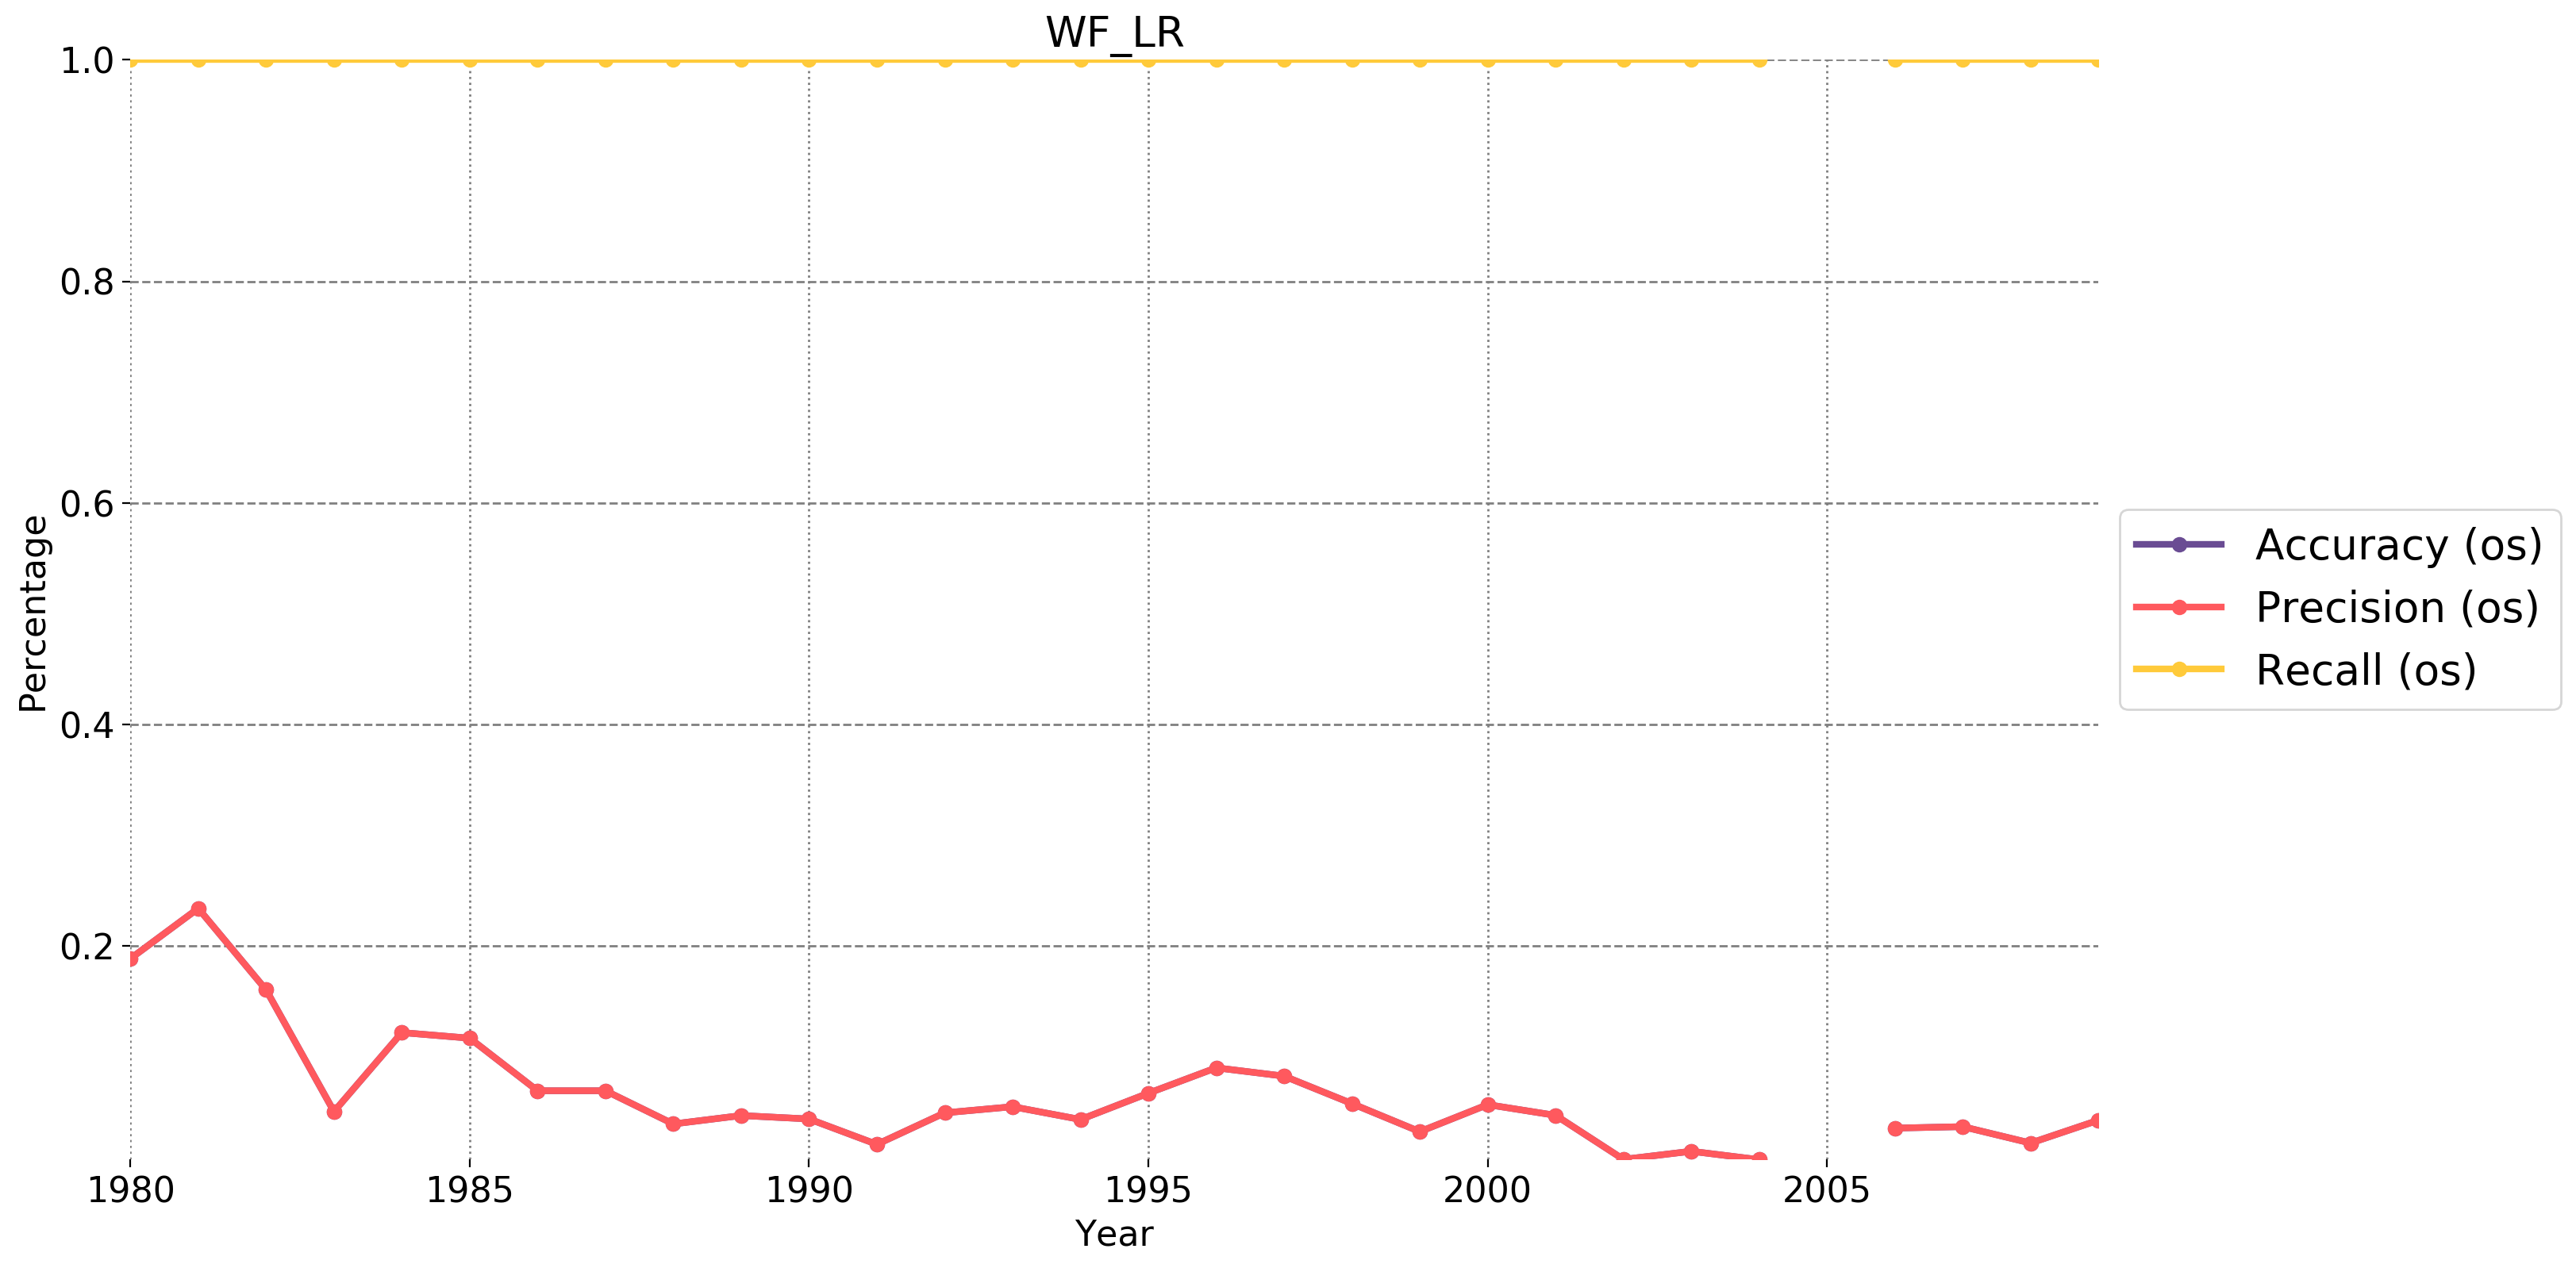

In [4]:
# Naive
from sklearn.linear_model import Perceptron
varlist = ["STDR", "M2R", "ResG"]
naive  = Perceptron()
adasyn5 = ADASYN(1.0, random_state=0)

output  = testing(data = pd_data, varlist = varlist, classifier = naive, start=1980, end=2010, past = all, future = 1, 
                title = "WF_LR", sampler = adasyn5, information = False)

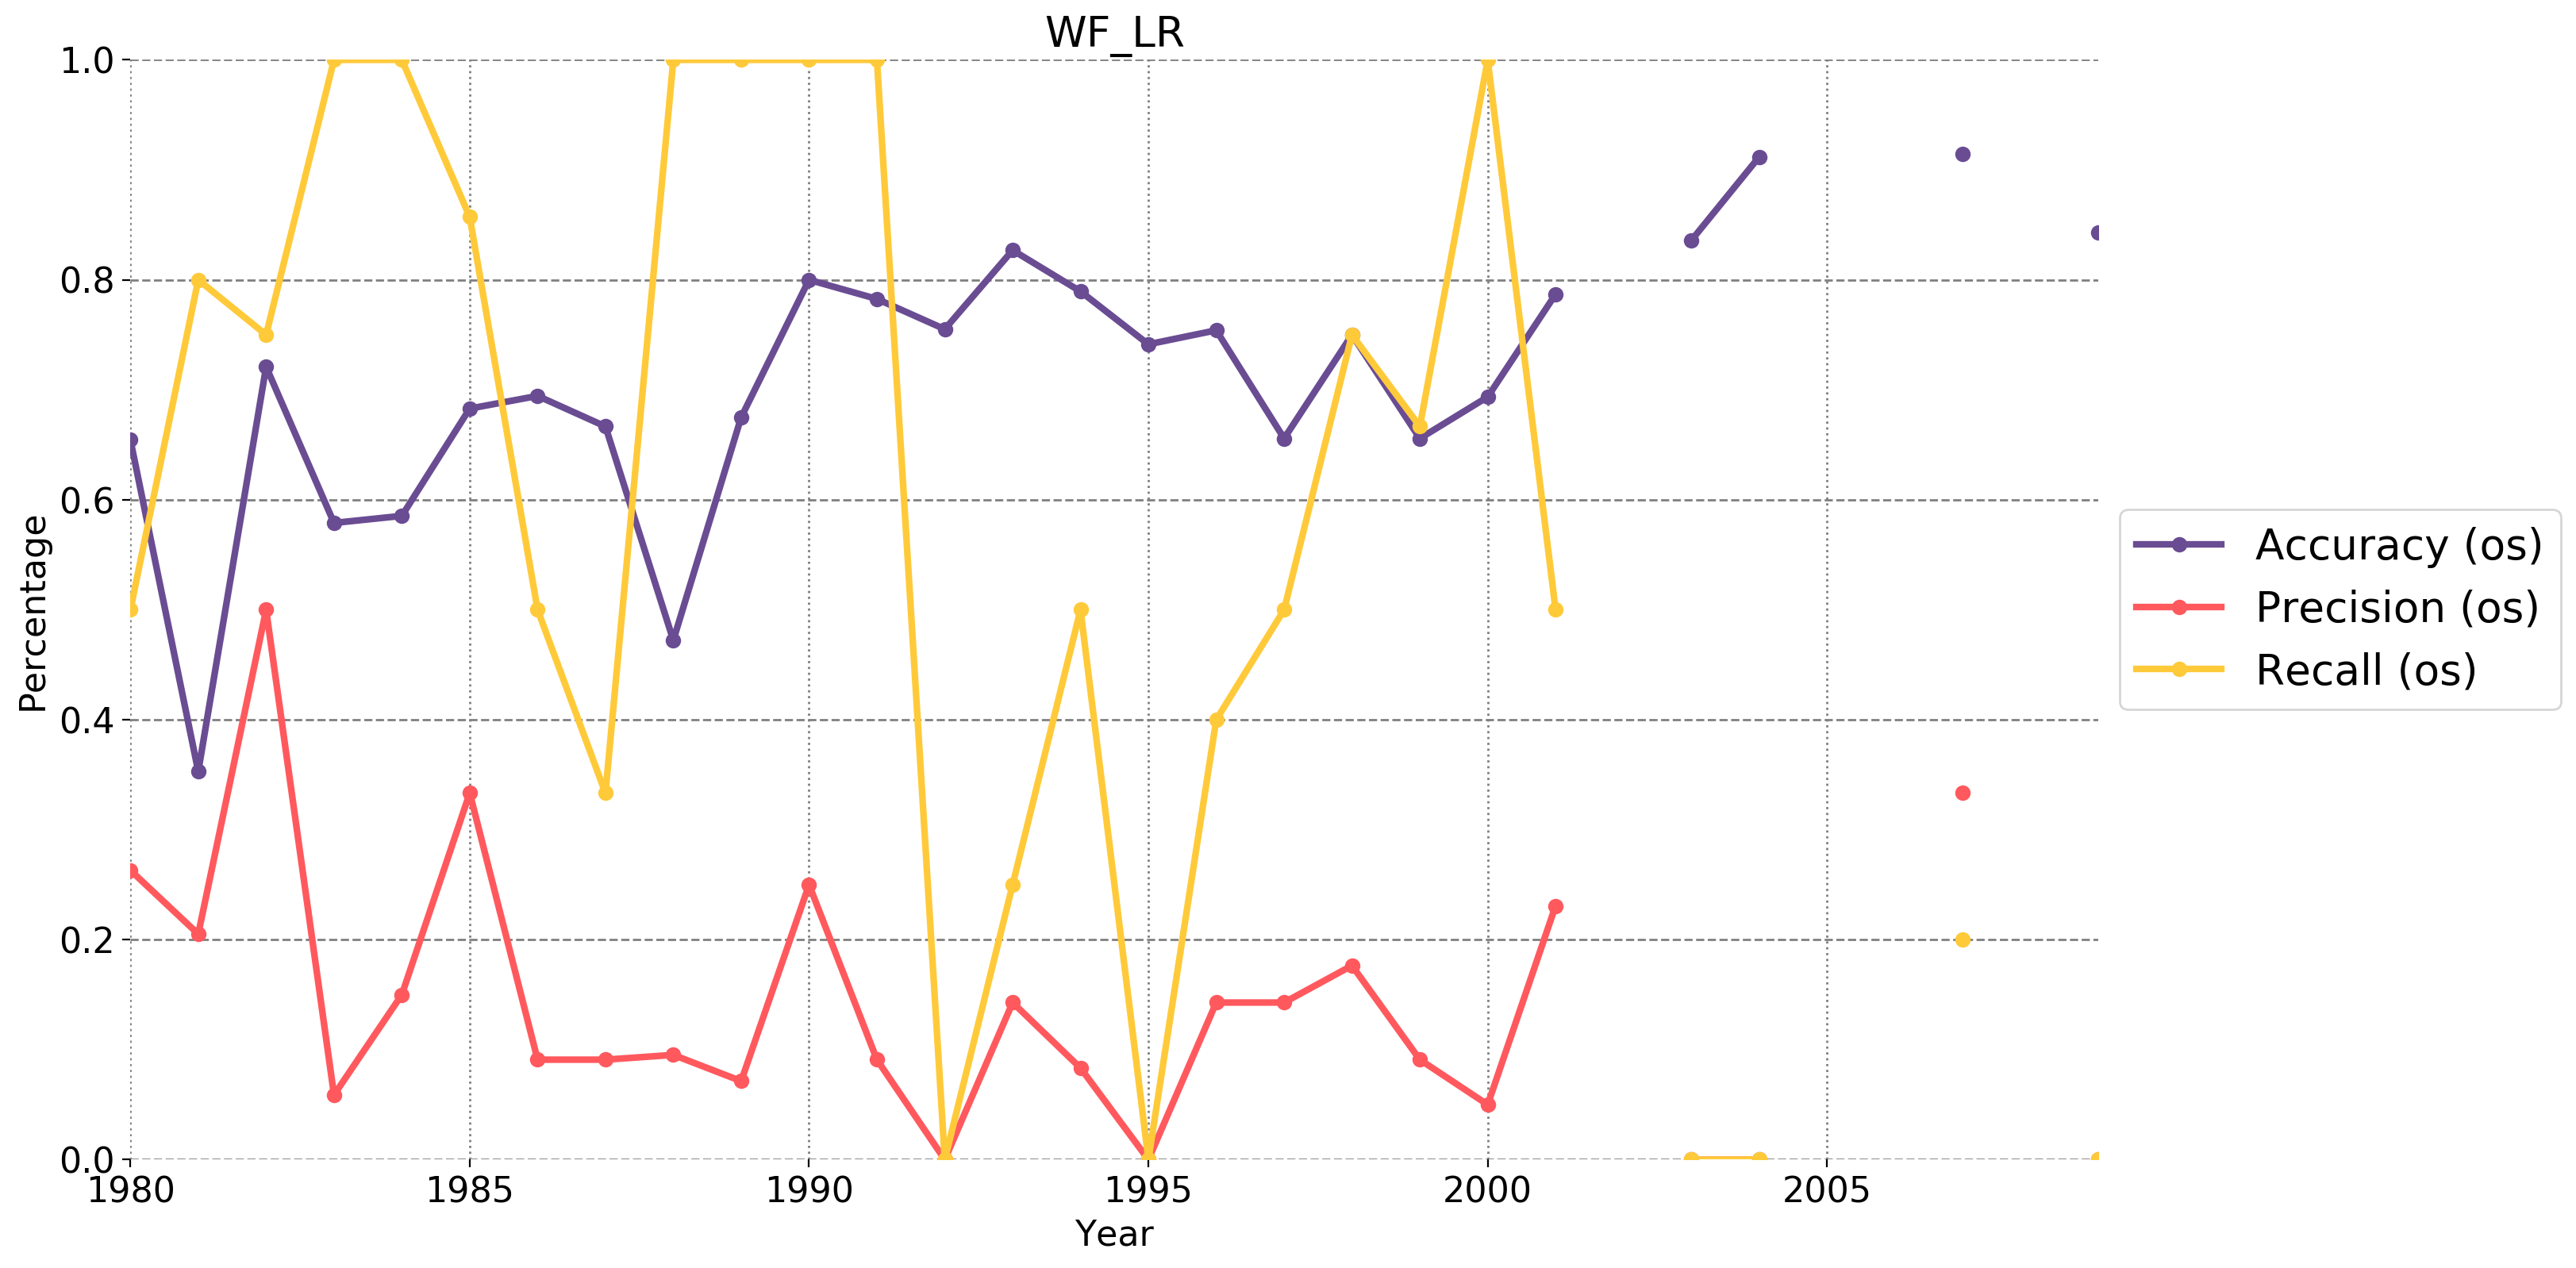

In [20]:
varlist = ["STDR", "M2R","ResG"]
lr1     = LogisticRegression(C=0.1) 
adasyn5 = ADASYN(1.0, random_state=0)

output  = testing(data = pd_data, varlist = varlist, classifier = lr1, start=1980, end=2010, past = all, future = 0, 
                title = "WF_LR", sampler = adasyn5, information = False)

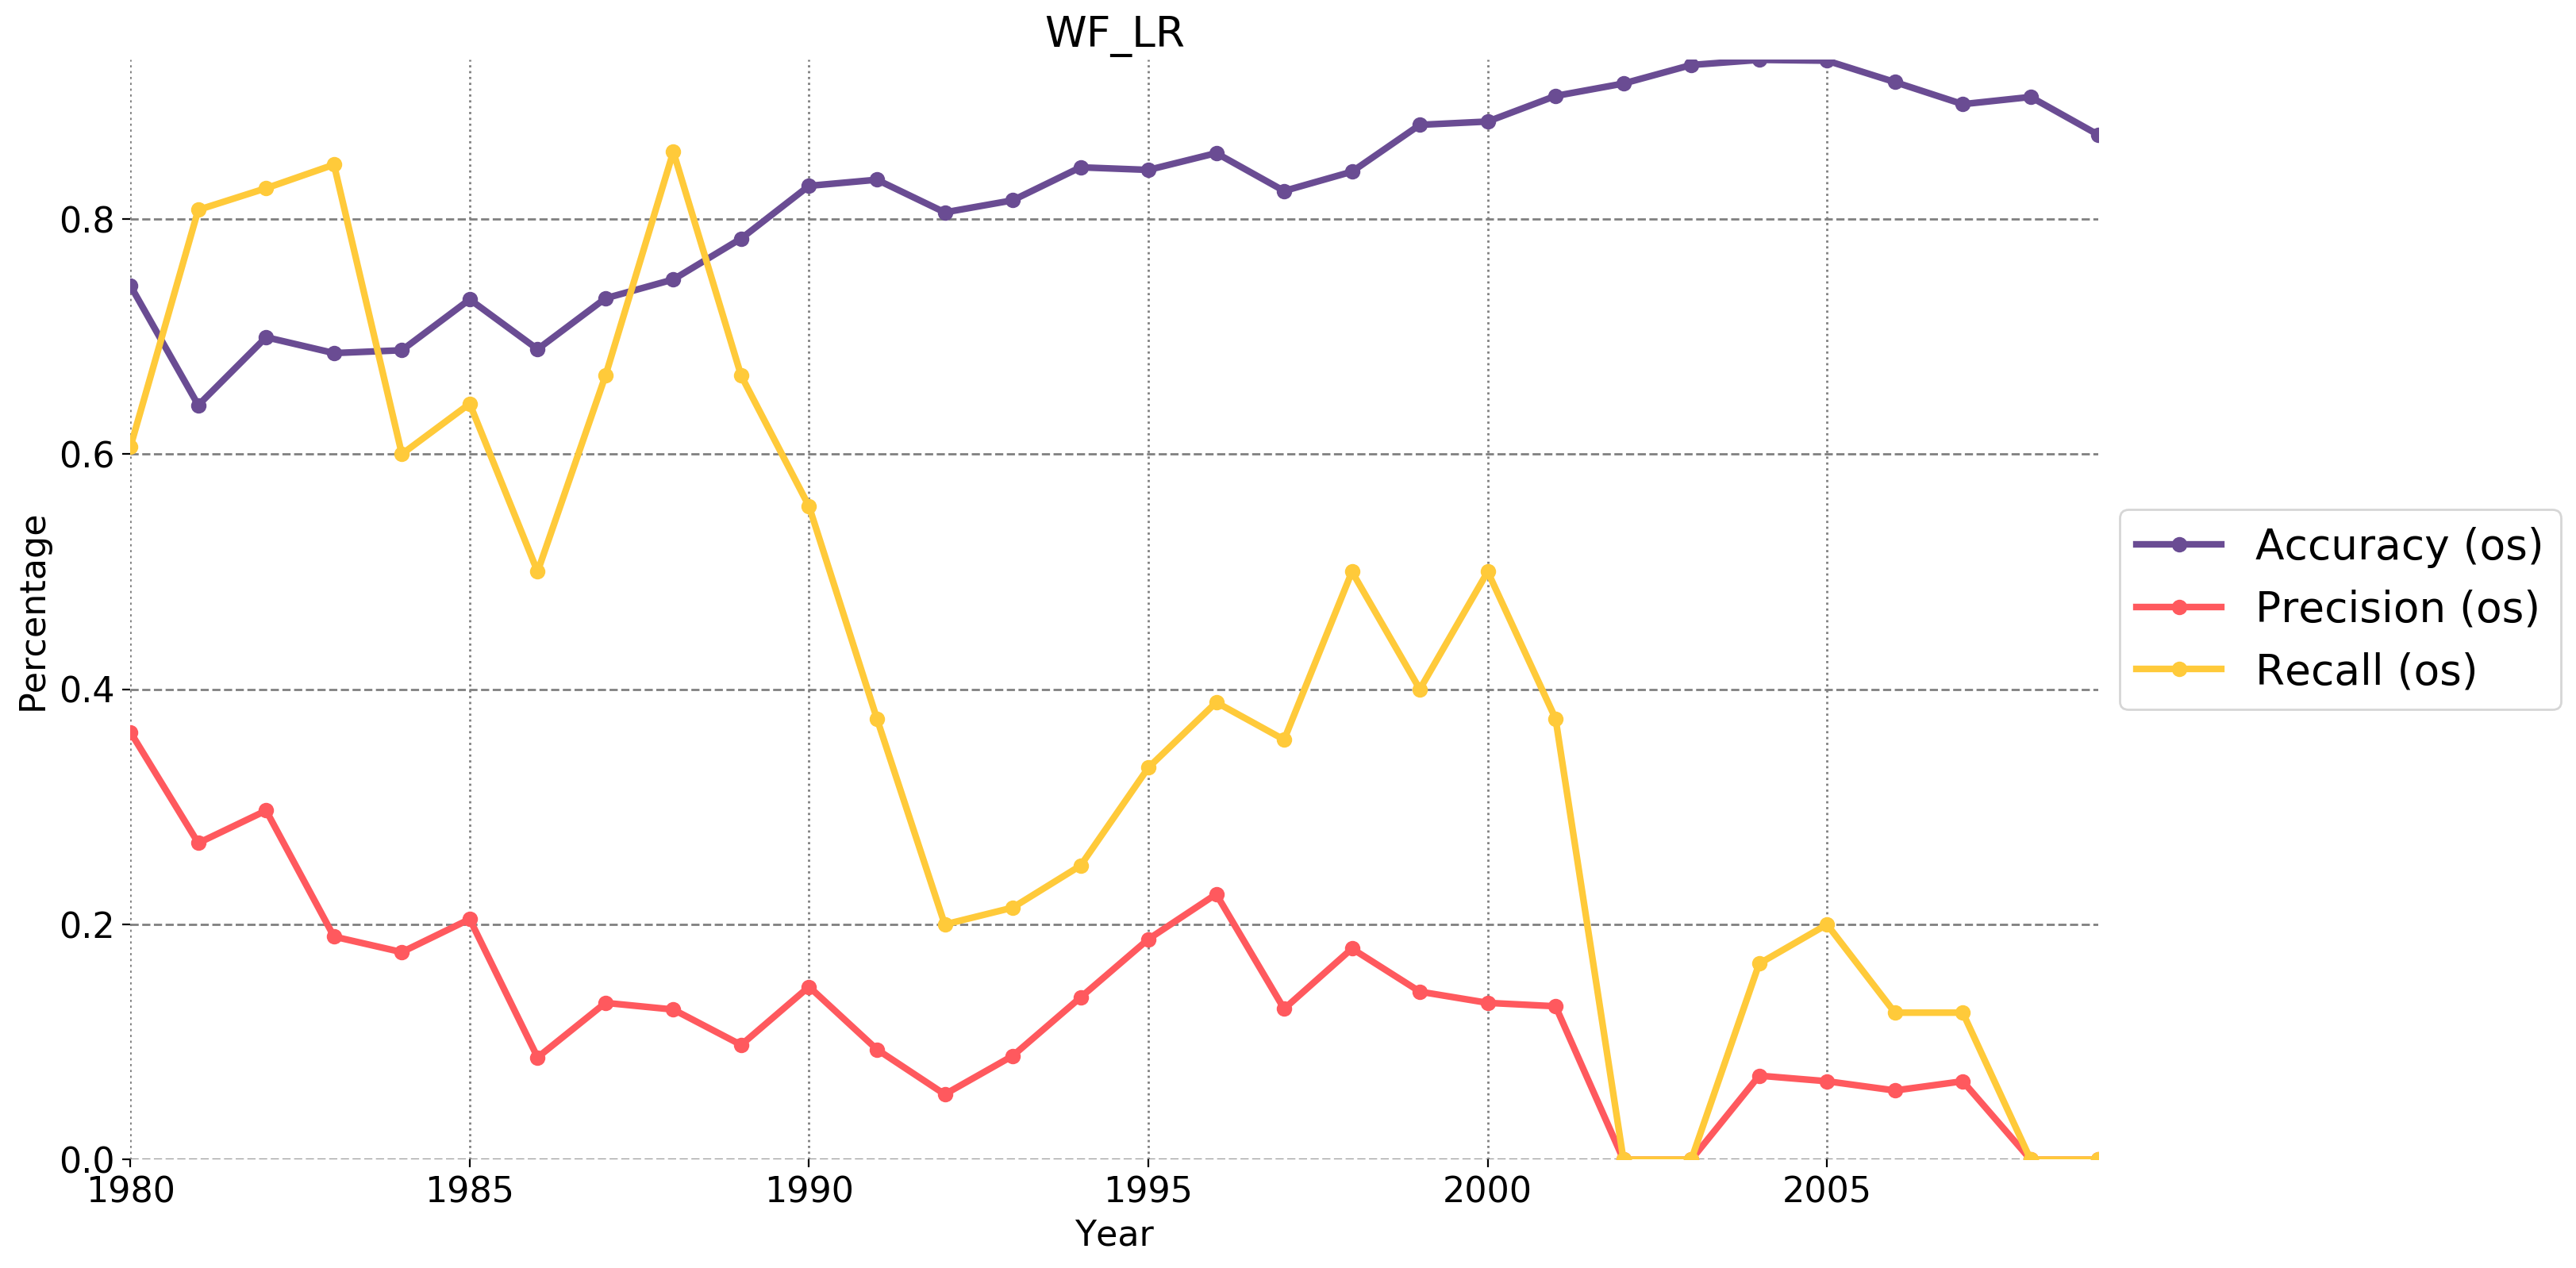

In [216]:
varlist = ["STDR", "M2R", "ResG", "DSER"]
tree1   = DecisionTreeClassifier(criterion='gini', max_depth=2 , random_state=1)
ros5    = RandomOverSampler(1.0, random_state=0)

output  = testing(data = pd_data, varlist = varlist, classifier = lr1, start=1980, end=2010, past = all, future = 3, 
                title = "WF_LR", sampler = ros5, information = False)

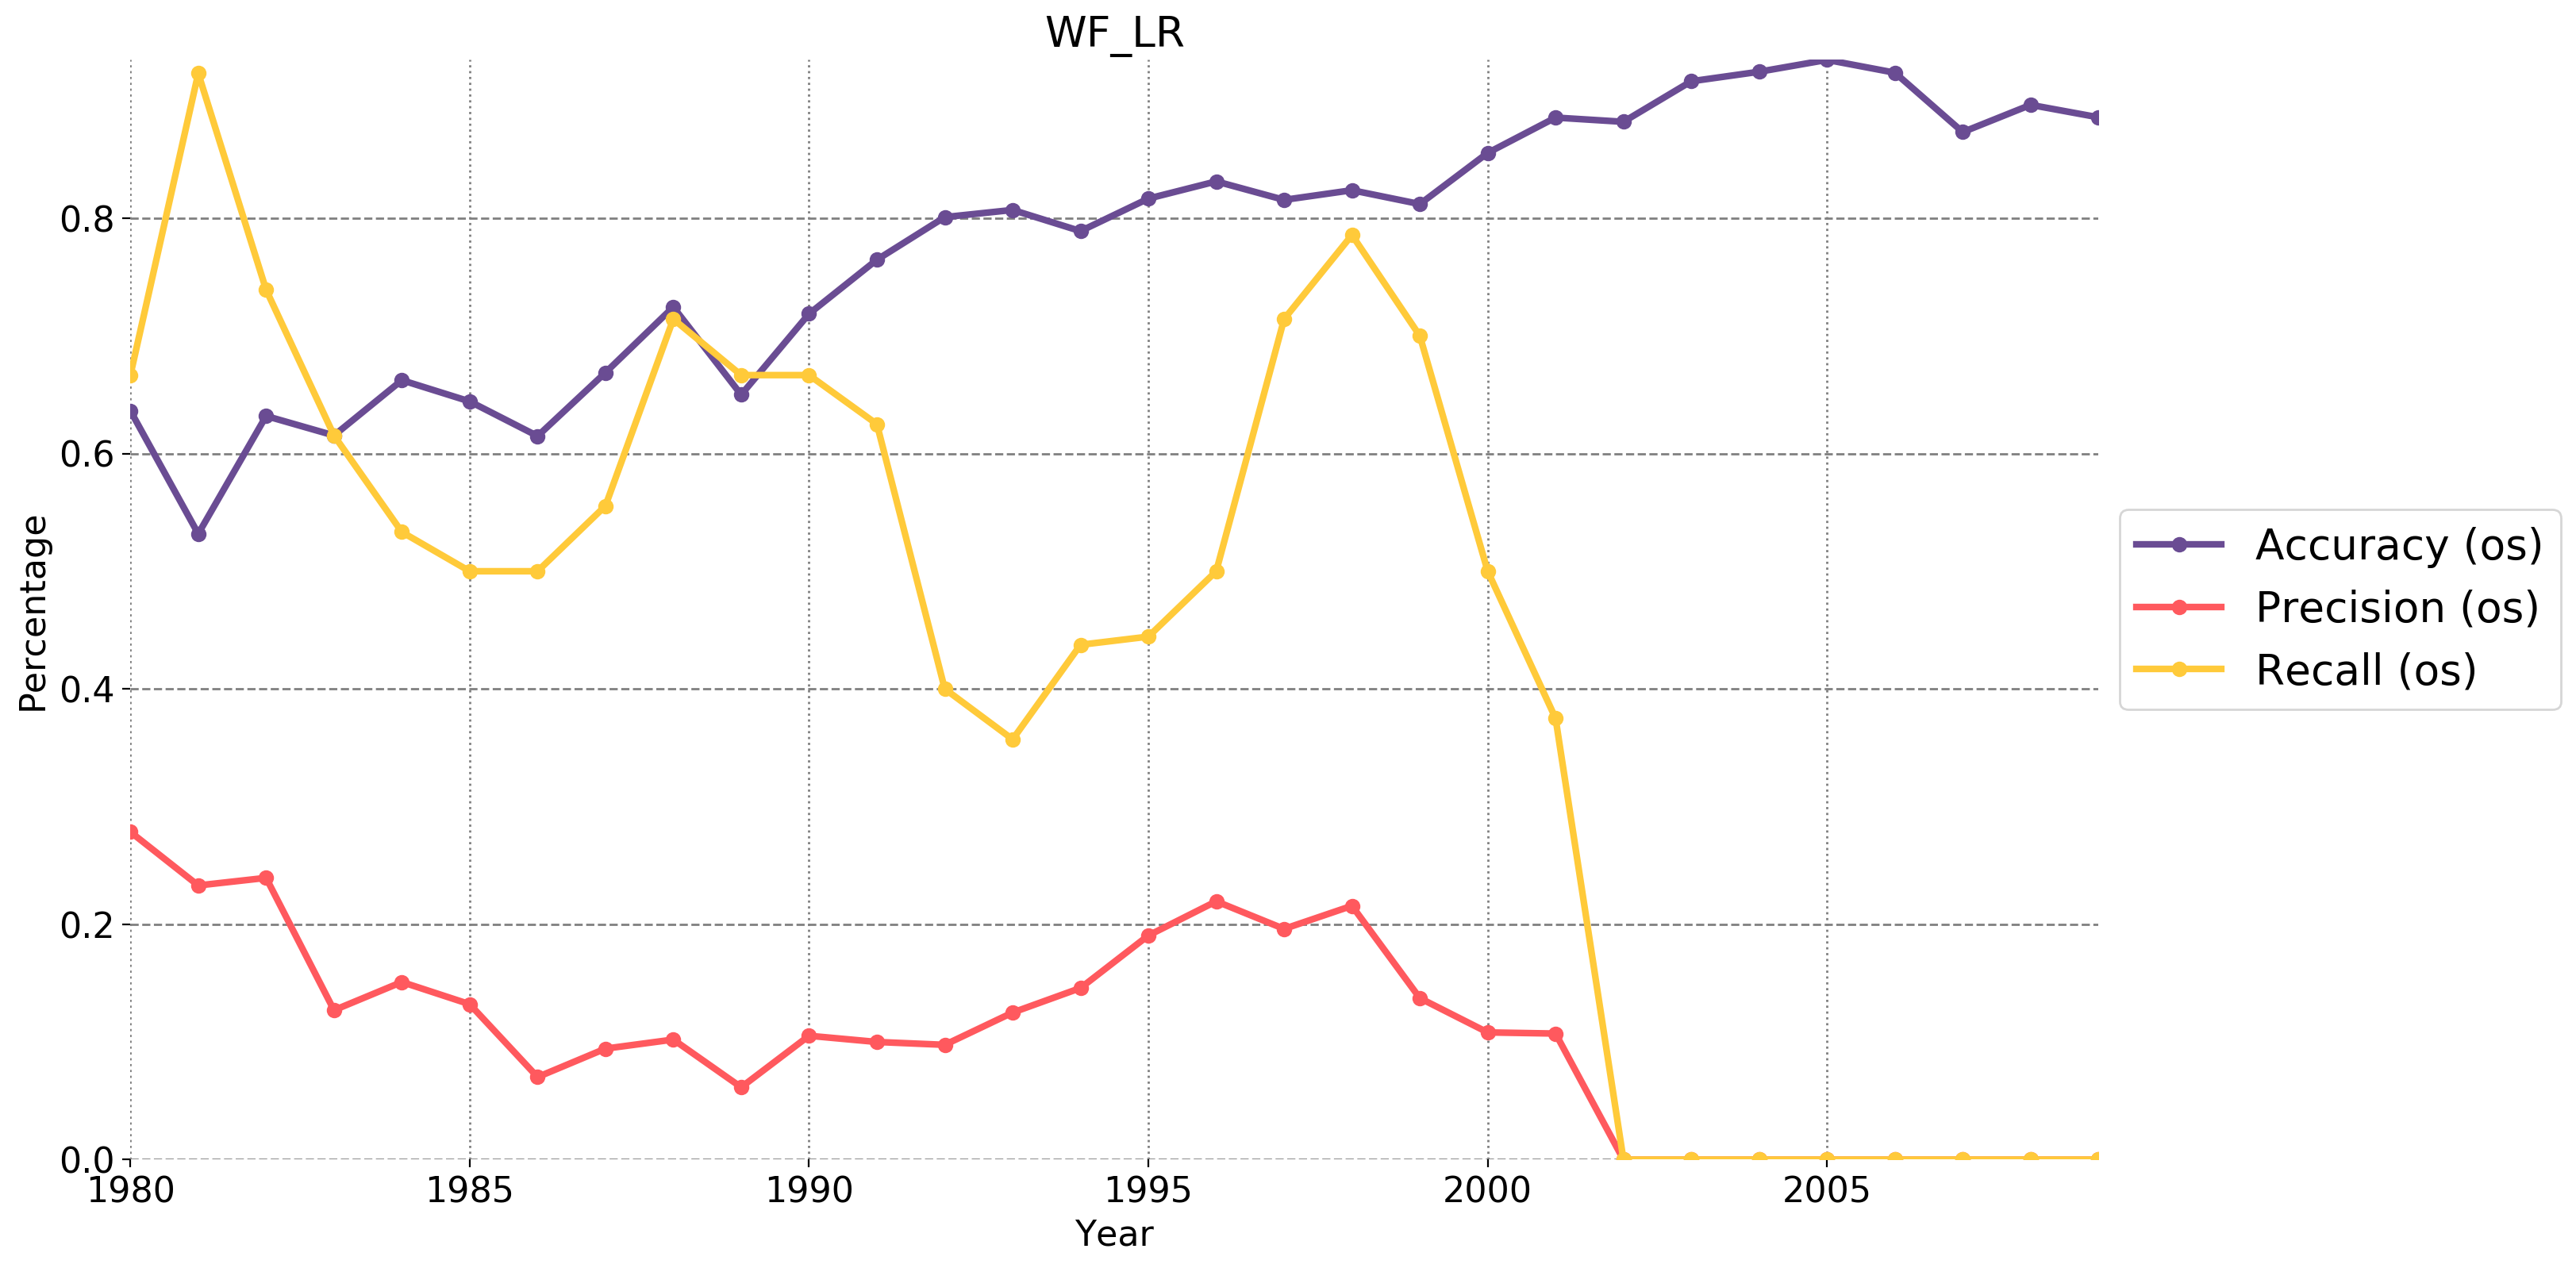

In [217]:
varlist = ["STDR", "M2R", "ResG", "DSER"]
xgb     = xgb.XGBClassifier(learning_rate=0.01, random_state=1)
adasyn5 = ADASYN(0.8, random_state=0)

output  = testing(data = pd_data, varlist = varlist, classifier = xgb, start=1980, end=2010, past = all, future = 3, 
                title = "WF_LR", sampler = adasyn5, information = False)

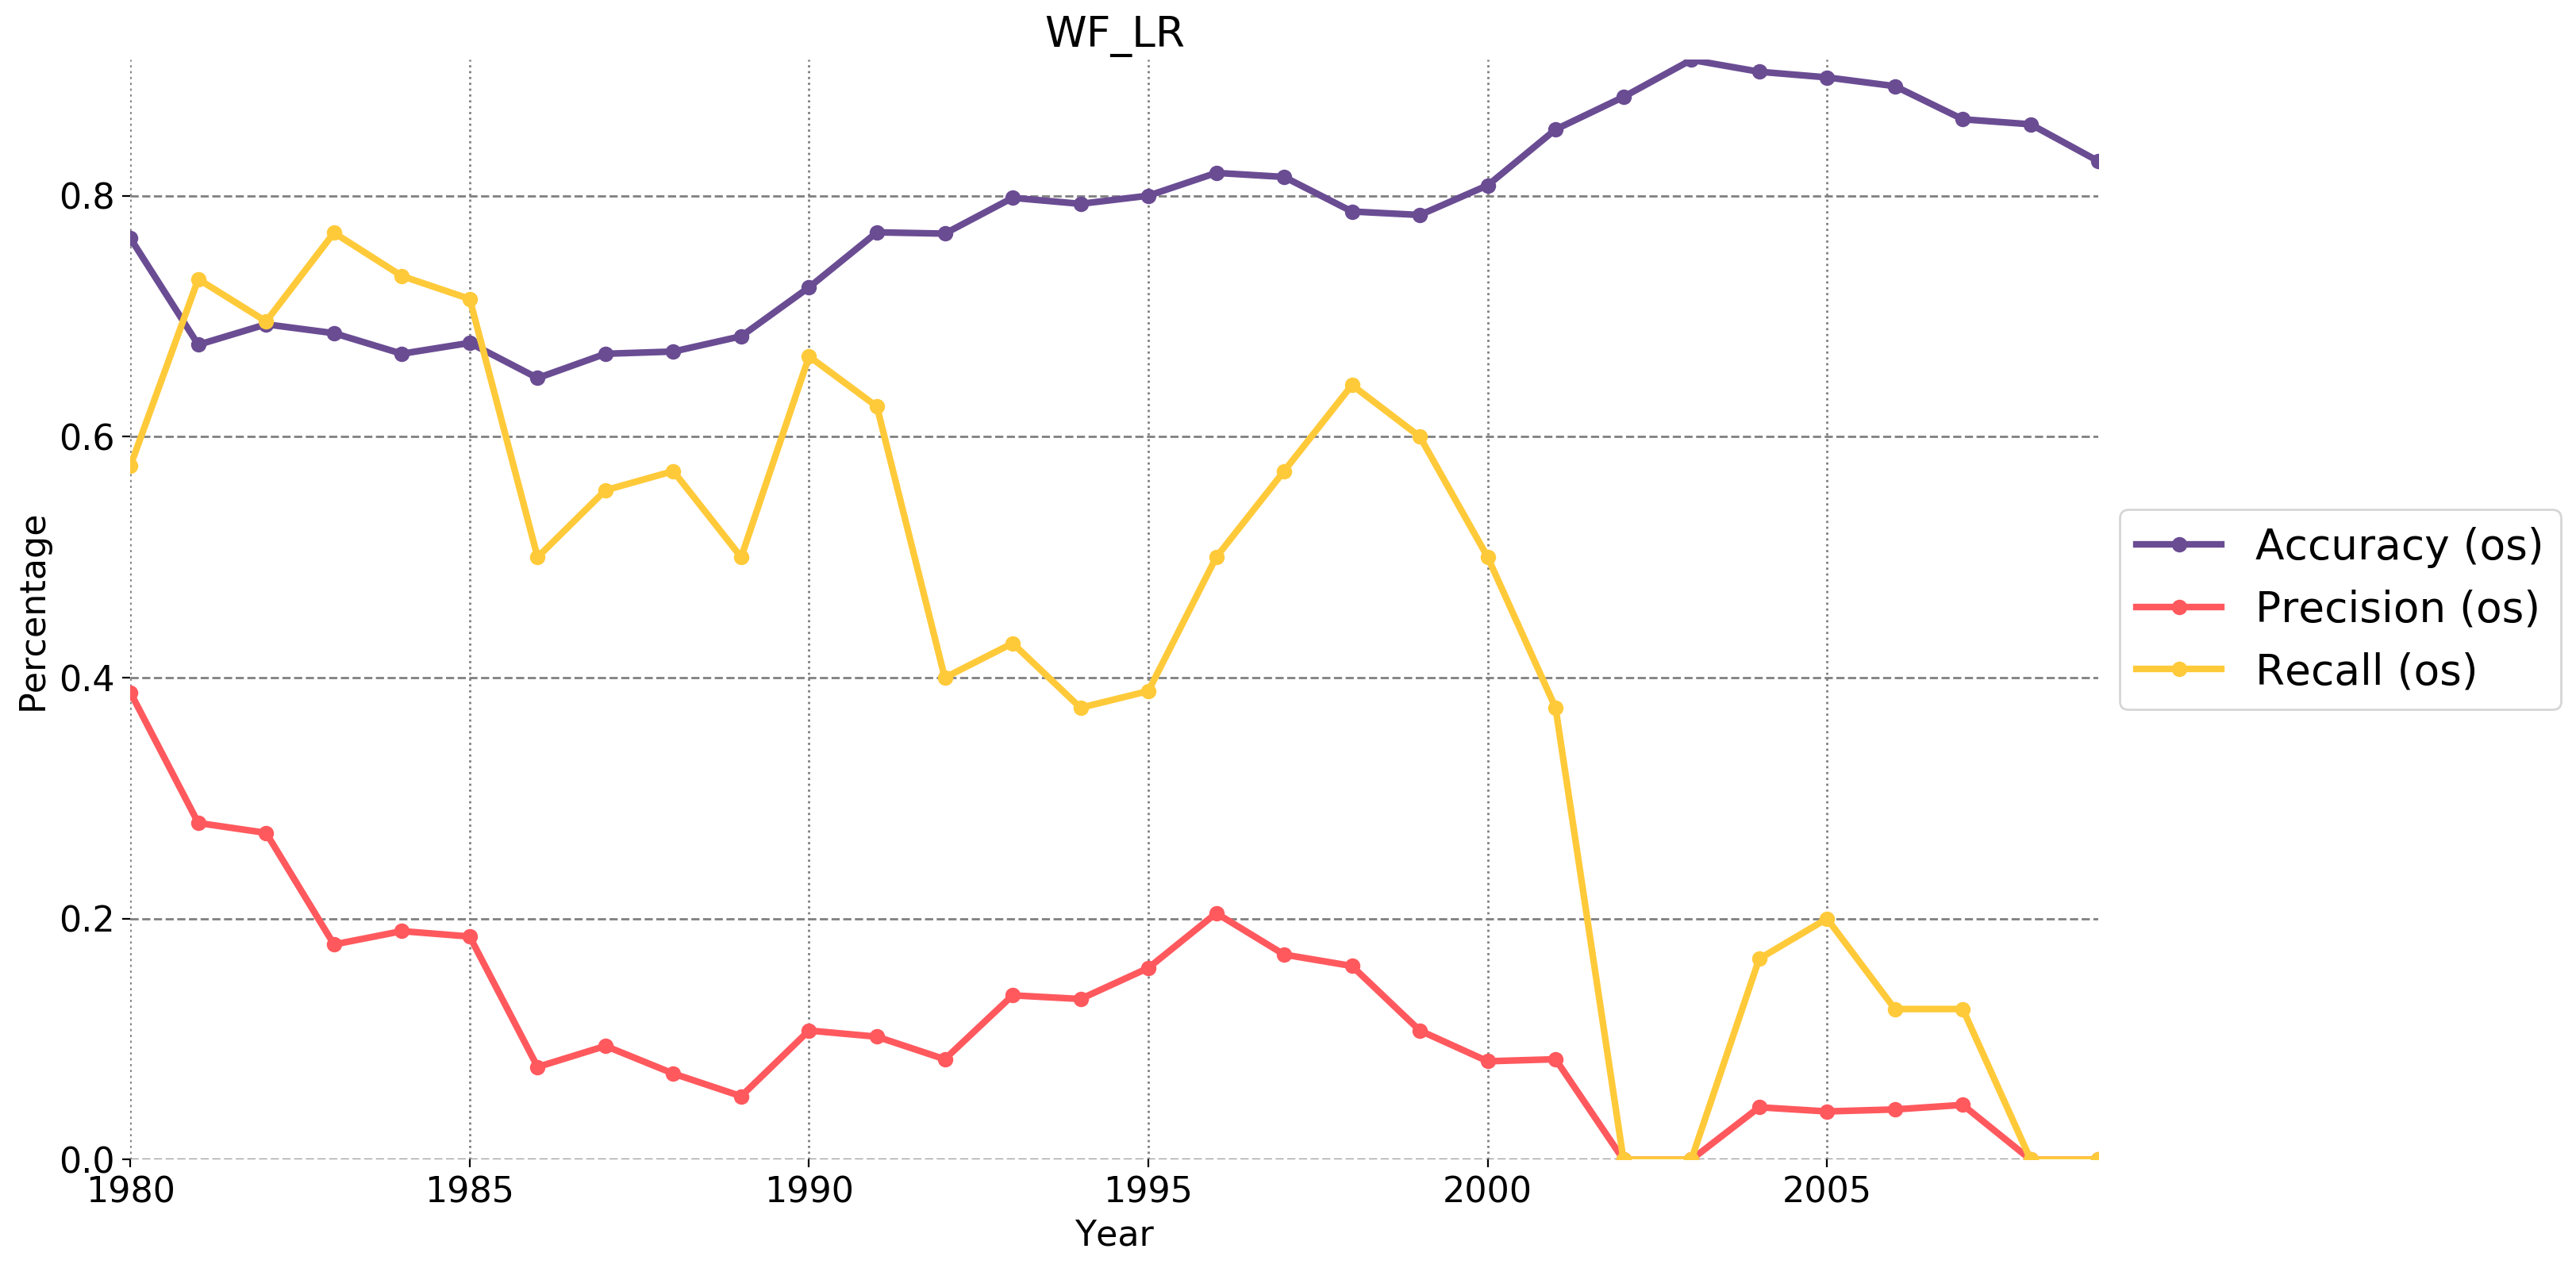

In [218]:
varlist = ["STDR", "M2R", "ResG", "DSER"]
svm4    = SVC(gamma=1, C=0.01, probability=True)
ros5    = RandomOverSampler(1.0, random_state=0)

output  = testing(data = pd_data, varlist = varlist, classifier = svm4, start=1980, end=2010, past = all, future = 3, 
                title = "WF_LR", sampler = ros5, information = False)

In [ ]:
tree1   = DecisionTreeClassifier(criterion='gini', max_depth=2 , random_state=1)
adasyn5 = ADASYN(1.0, random_state=0)

output  = testing(data = pd_data, varlist = varlist4, classifier = lr1, start=1980, end=2010, past = all, future = 1, 
                title = "WF_LR", sampler = adasyn5, information = False)

## Penalizing

# naive  = Perceptron()
classifiers_naive = [naive]

lr1     = LogisticRegression(C=1, class_weight = {0:1, 1:5})
lr2     = LogisticRegression(C=1, class_weight = {0:1, 1:10})
lr3     = LogisticRegression(C=1, class_weight = {0:1, 1:15})
lr4     = LogisticRegression(C=1, class_weight = {0:1, 1:20})
lr5     = LogisticRegression(C=1, class_weight = {0:1, 1:25})
lr6     = LogisticRegression(C=1, class_weight = {0:1, 1:30})
classifiers_lr = [lr1, lr2, lr3, lr4, lr5, lr6]

tree1   = DecisionTreeClassifier(criterion='gini', max_depth=2 , random_state=1, class_weight = {0:1, 1:5}) 
tree2   = DecisionTreeClassifier(criterion='gini', max_depth=2 , random_state=1, class_weight = {0:1, 1:10}) 
tree3   = DecisionTreeClassifier(criterion='gini', max_depth=2 , random_state=1, class_weight = {0:1, 1:15})
tree4   = DecisionTreeClassifier(criterion='gini', max_depth=2 , random_state=1, class_weight = {0:1, 1:20})
tree5   = DecisionTreeClassifier(criterion='gini', max_depth=2 , random_state=1, class_weight = {0:1, 1:25})
tree6   = DecisionTreeClassifier(criterion='gini', max_depth=2 , random_state=1, class_weight = {0:1, 1:30})
classifiers_tree = [tree1, tree2, tree3, tree4, tree5, tree6]

forest1 = RandomForestClassifier(criterion='gini', n_estimators=25, random_state=1, class_weight = {0:1, 1:5}) # 2
forest2 = RandomForestClassifier(criterion='gini', n_estimators=25, random_state=1, class_weight = {0:1, 1:10})
forest3 = RandomForestClassifier(criterion='gini', n_estimators=25, random_state=1, class_weight = {0:1, 1:15})
forest4 = RandomForestClassifier(criterion='gini', n_estimators=25, random_state=1, class_weight = {0:1, 1:20})
forest5 = RandomForestClassifier(criterion='gini', n_estimators=25, random_state=1, class_weight = {0:1, 1:25})
forest6 = RandomForestClassifier(criterion='gini', n_estimators=25, random_state=1, class_weight = {0:1, 1:30})
classifiers_forest = [forest1, forest2, forest3, forest4, forest5, forest6]

svm1 = SVC(gamma=0.1, C=100, probability=True, class_weight = {0:1, 1:5}) # 3
svm2 = SVC(gamma=0.1, C=100, probability=True, class_weight = {0:1, 1:10})
svm3 = SVC(gamma=0.1, C=100, probability=True, class_weight = {0:1, 1:15})
svm4 = SVC(gamma=0.1, C=100, probability=True, class_weight = {0:1, 1:20})
svm5 = SVC(gamma=0.1, C=100, probability=True, class_weight = {0:1, 1:25})
svm6 = SVC(gamma=0.1, C=100, probability=True, class_weight = {0:1, 1:30})
classifiers_svm = [svm1, svm2, svm3, svm4, svm5, svm6]


xgb1    = xgb.XGBClassifier(learning_rate=0.01, random_state=1, scale_pos_weight=1) 
xgb2    = xgb.XGBClassifier(learning_rate=0.01, random_state=1, scale_pos_weight=10)
xgb3    = xgb.XGBClassifier(learning_rate=0.01, random_state=1, scale_pos_weight=50) 
xgb4    = xgb.XGBClassifier(learning_rate=0.01, random_state=1, scale_pos_weight=100) 
xgb5    = xgb.XGBClassifier(learning_rate=0.01, random_state=1, scale_pos_weight=1000) 
classifiers_xgb = [xgb1, xgb2, xgb3, xgb4, xgb5]

classifiers_list = [classifiers_naive, classifiers_lr, classifiers_tree, classifiers_forest, classifiers_svm, classifiers_xgb]
# classifiers_list = [classifiers_naive, classifiers_lr]
